In [1]:
%load_ext autoreload
%autoreload 2

from multicamera_acquisition.acquisition import refactor_acquire_video, AcquisitionLoop
from multicamera_acquisition.writer import NVC_Writer, FFMPEG_Writer
from multicamera_acquisition.interfaces.microcontroller import Microcontroller 
from multicamera_acquisition.visualization import MultiDisplay
from multicamera_acquisition.interfaces.config import (
    partial_config_from_camera_list,
    create_full_camera_default_config,
)


In [3]:
# Run the func!
import logging

def reset_loggers():
    # Remove handlers from all loggers
    for logger in logging.Logger.manager.loggerDict.values():
        if isinstance(logger, logging.Logger):  # Guard against 'PlaceHolder' objects
            logger.handlers.clear()

    # Reset the root logger
    logging.getLogger().handlers.clear()

In [19]:
camera_list = [
    {"name": "side3",  "brand": "basler", "id": "40332773", "gain": 25, "exposure": 1000},
    {"name": "side4",  "brand": "basler", "id": "40347935", "gain": 25, "exposure": 1000},
    {"name": "side2",  "brand": "basler", "id": "40347941", "gain": 25, "exposure": 1000},
    {"name": "side1",  "brand": "basler", "id": "40347943", "gain": 26, "exposure": 1000, "roi": (0,96,1920,1104)},
    {"name": "top",    "brand": "basler", "id": "40393557", "gain": 25, "exposure": 1000, "roi": (128,0,1440,1200)},
    {"name": "bottom", "brand": "basler", "id": "40393560", "gain": 22, "exposure": 1000, "roi": (448,0,1248,1200)},
    {"name": "azure_top",    "brand": "azure", "id": "000500221712", "subordinate_delay_off_master_usec": 160},
    {"name": "azure_bottom", "brand": "azure", "id": "000693321712", "subordinate_delay_off_master_usec": 0},    
]

# Set the trigger behavior
for camera in camera_list[:6]:
    camera["trigger_type"] = "microcontroller"

# Recording params
fps = 120
tmp_path = R'D:\Jonah\2023_12_26_6cam_testing\tmp'
logging_level = "INFO"

In [20]:
# Parse the "camera list" into a partial config
partial_new_config = partial_config_from_camera_list(camera_list)

# Add writer configs to each ir camera config
for camera_name in partial_new_config["cameras"].keys():
    if partial_new_config["cameras"][camera_name]["brand"] != "basler":
        continue
    ir_writer_config = NVC_Writer.default_writer_config(fps).copy()
    ir_writer_config["camera_name"] = camera_name
    partial_new_config["cameras"][camera_name]["writer"] = ir_writer_config

# Add writer config for the azure cameras
for camera_name in partial_new_config["cameras"].keys():
    if partial_new_config["cameras"][camera_name]["brand"] != "azure":
        continue
    az_ir_config = FFMPEG_Writer.default_writer_config(30, vid_type="ir", gpu=None).copy()
    az_dp_config = FFMPEG_Writer.default_writer_config(30, vid_type="depth", gpu=None).copy()
    az_ir_config["camera_name"] = camera_name
    az_dp_config["camera_name"] = camera_name
    partial_new_config["cameras"][camera_name]["writer"] = az_ir_config
    partial_new_config["cameras"][camera_name]["writer_depth"] = az_dp_config



In [21]:
# Create the full config, filling in defaults where necessary
full_config = create_full_camera_default_config(partial_new_config, fps)
full_config["globals"] = {}
full_config["globals"]["fps"] = fps
full_config["globals"]["microcontroller_required"] =True

# Set up the acquisition loop part of the config
acq_config = AcquisitionLoop.default_acq_loop_config().copy()
full_config["acq_loop"] = acq_config

# Set up the Microcontroller part of the config
full_config["microcontroller"] = Microcontroller.default_microcontroller_config()
# full_config["microcontroller"]["top_camera_pins"] = [1, 5, 7, 9, 11, 33]  # 33 is a "fictive camera" for syncing
full_config["microcontroller"]["top_camera_pins"] = [9, 11, 33, 1, 5, 7]
full_config["microcontroller"]["top_light_pins"] = [38, 39, 40, 41]
full_config["microcontroller"]["bottom_camera_pins"] = [3]
full_config["microcontroller"]["bottom_light_pins"] = [14, 15, 16, 17]
full_config["microcontroller"]["random_output_pins"] = [34]  # also 35?
full_config["microcontroller"]["input_pins"] = [] 

full_config["rt_display"] = MultiDisplay.default_MultiDisplay_config()

In [22]:
full_config["microcontroller"]

{'azure_trigger_pins': [0],
 'top_camera_pins': [9, 11, 33, 1, 5, 7],
 'bottom_camera_pins': [3],
 'input_pins': [],
 'top_light_pins': [38, 39, 40, 41],
 'bottom_light_pins': [14, 15, 16, 17],
 'top_light_dur': None,
 'bottom_light_dur': None,
 'random_output_pins': [34],
 'custom_output_pins': [],
 'custom_output_times': [],
 'custom_output_states': [],
 'azure_pulse_dur': 100,
 'basler_pulse_dur': 100,
 'bottom_camera_offset': 100,
 'gap_between_azure_and_basler': 50,
 'trigger_plot_figsize': (12, 3),
 'plot_trigger_schedule': True,
 'microcontroller_port': None,
 'cycles_per_random_bit_flip': 1}

In [23]:
logging_level = "INFO"

In [24]:
rec_time_s = 120

2024-01-29 10:22:19,117 - main_acq_logger - INFO - Finding microcontroller...
2024-01-29 10:22:19,302 - main_acq_logger - INFO - Found ready microcontroller on port: COM3
2024-01-29 10:22:19,305 - main_acq_logger - INFO - Opening subprocesses and cameras, this may take a moment...
2024-01-29 10:22:29,575 - main_acq_logger - INFO - Starting cameras...
2024-01-29 10:22:30,530 - main_acq_logger - INFO - Starting microcontroller...


Recording Progress: 99.17% (119 / 120 sec)

2024-01-29 10:24:31,287 - main_acq_logger - INFO - Ending processes, this may take a moment...
2024-01-29 10:24:32,962 - main_acq_logger - INFO - Processed ended
2024-01-29 10:24:32,967 - main_acq_logger - INFO - Done.


Recording Progress: 100%

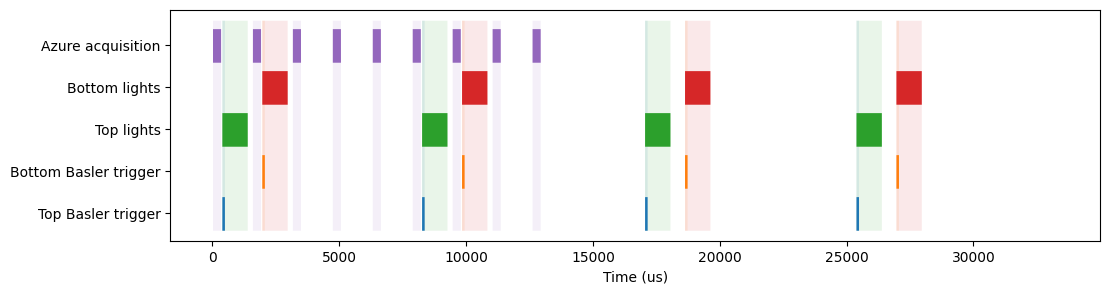

In [25]:
reset_loggers()

save_loc, first_video_file_name, full_config = refactor_acquire_video(
    tmp_path,
    full_config,
    recording_duration_s=rec_time_s,
    append_datetime=True,
    overwrite=False,
    logging_level=logging_level
)

In [26]:
from pathlib2 import Path
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import os
from os.path import join, exists
from multicamera_acquisition.video_utils import count_frames
plt.set_loglevel (level = 'warning')

In [27]:
# save_loc = R"D:\Jonah\2023_12_26_6cam_testing\tmp\90hz"

side3 cam: 14400 frames
side4 cam: 14400 frames
side2 cam: 14400 frames
side1 cam: 14400 frames
top cam: 14400 frames
bottom cam: 14400 frames
azure_top cam: 3624 frames
azure_bottom cam: 3637 frames


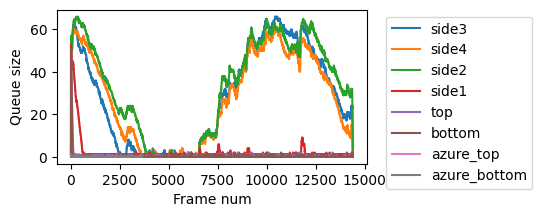

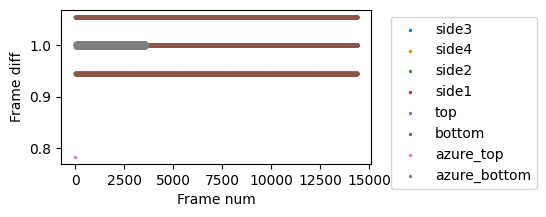

In [29]:
_, qsize_ax = plt.subplots(figsize=(4,2))
_, frame_diff_ax = plt.subplots(figsize=(4,2))
for cam in camera_list:
    name = cam["name"]
    
    # Count frames in videos
    vid = glob.glob(join(str(save_loc), f'*.{name}*.mp4'))[0]
    nframes = count_frames(vid)
    print(f"{name} cam: {nframes} frames")
    
    df = pd.read_csv(glob.glob(str(save_loc)+ f'\*.{name}.metadata.csv')[0])
    
    qsize_ax.plot(df.queue_size.values, label=name)
    qsize_ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    qsize_ax.set(xlabel='Frame num', ylabel='Queue size')

    frame_diff_ax.scatter(
        df.frames_received[1:],
        np.diff(df.frame_timestamp.values) / np.median(np.diff(df.frame_timestamp.values)), 
        s=2,
        label=name
    )
    frame_diff_ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    frame_diff_ax.set(xlabel='Frame num', ylabel='Frame diff')

side3


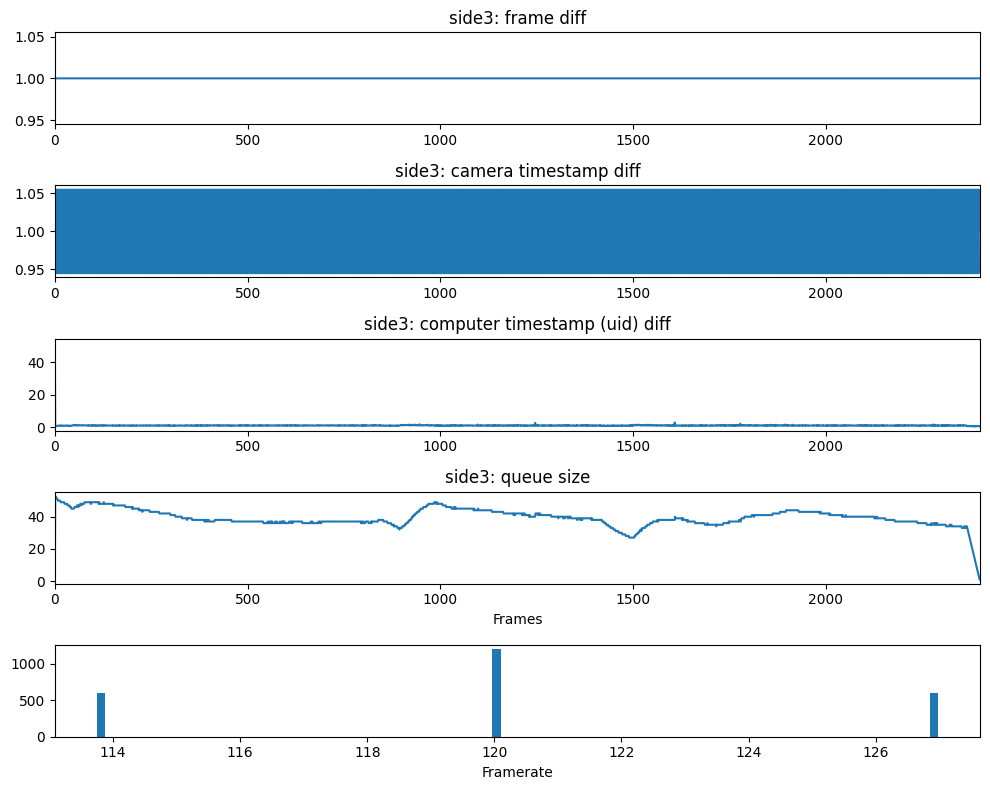

19.992
119.99868964832282
side4


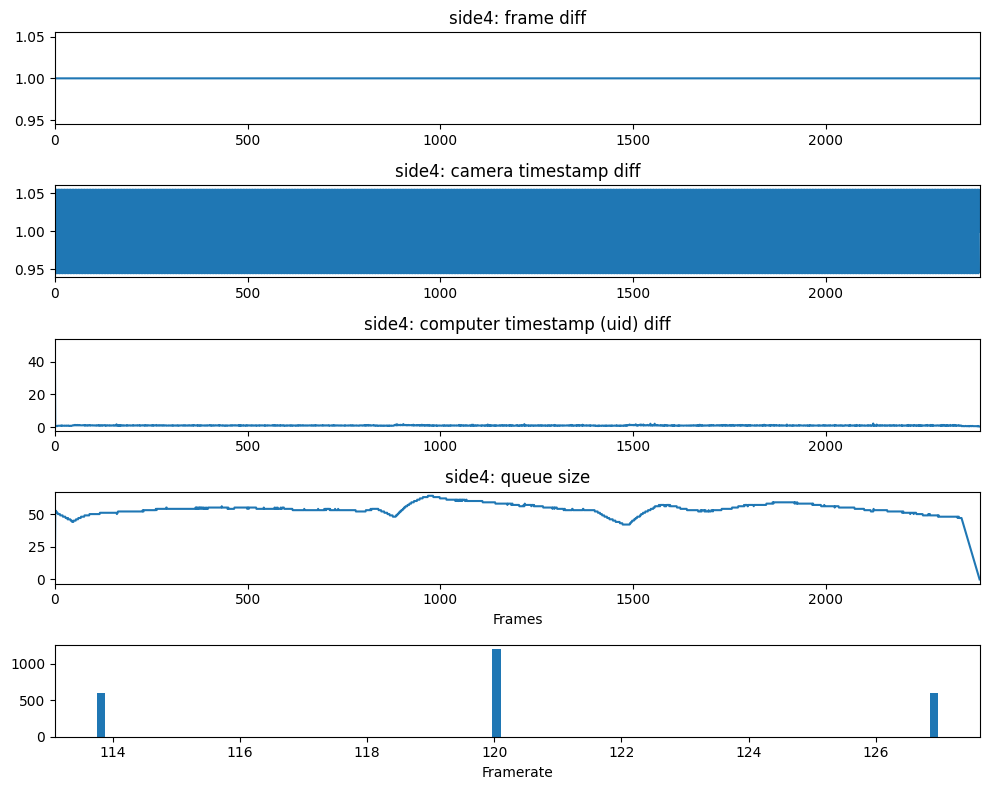

19.992
119.998521522176
side2


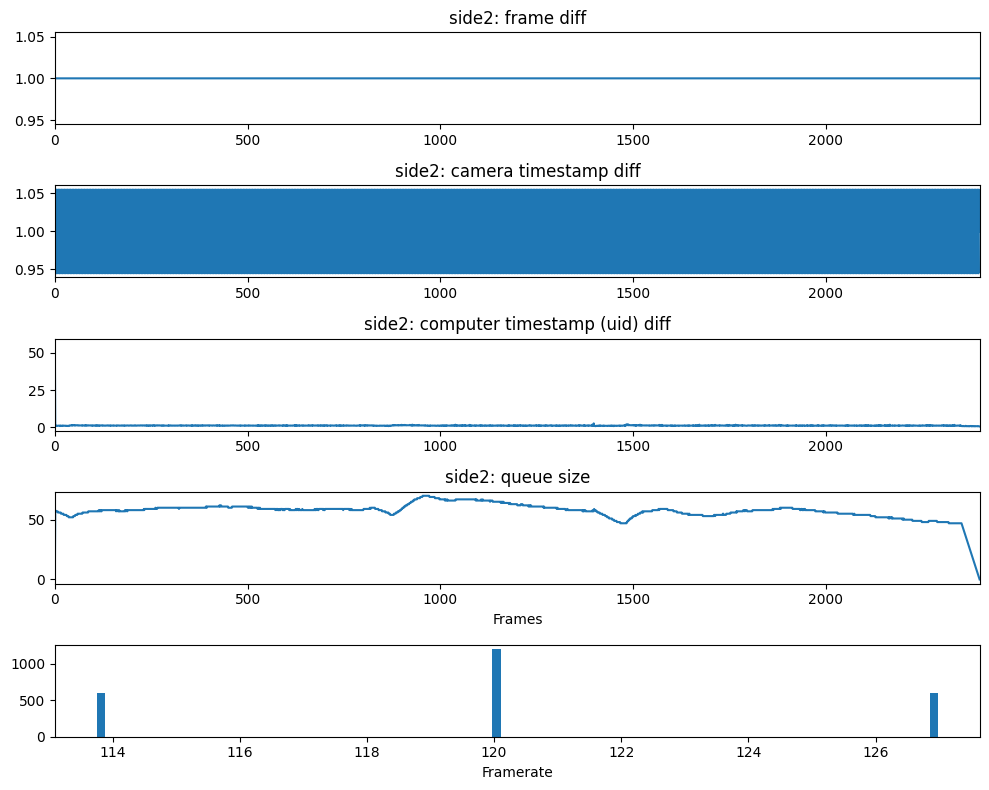

19.992
119.9983379104746
side1


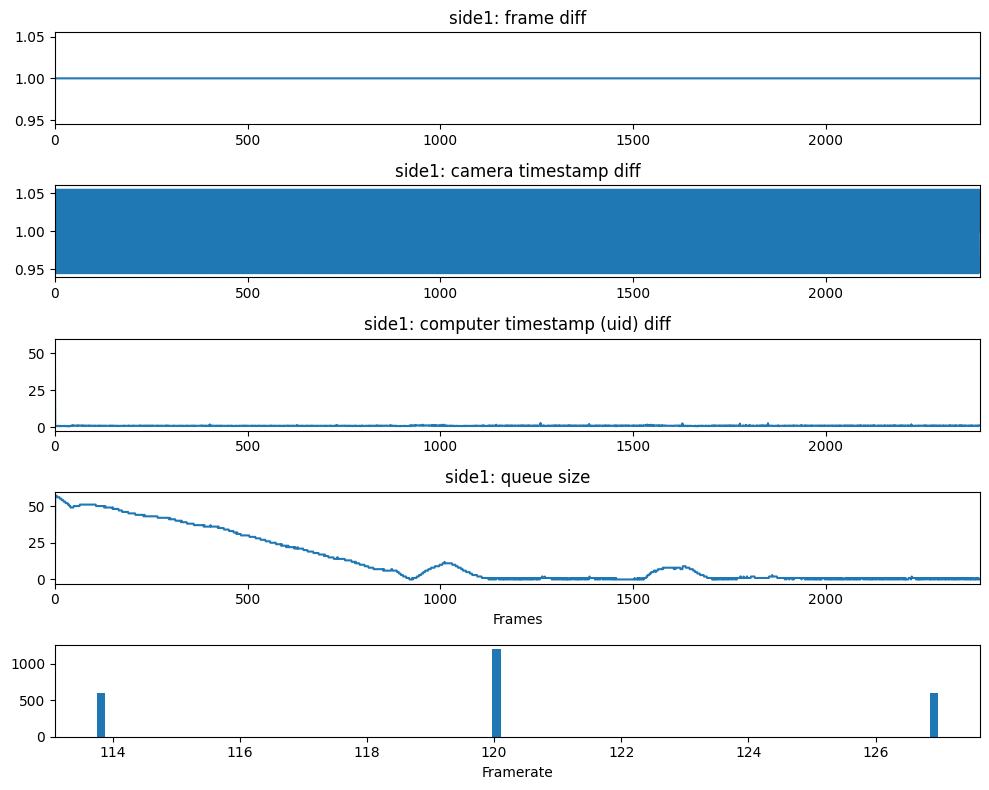

19.992
119.99857068146831
top


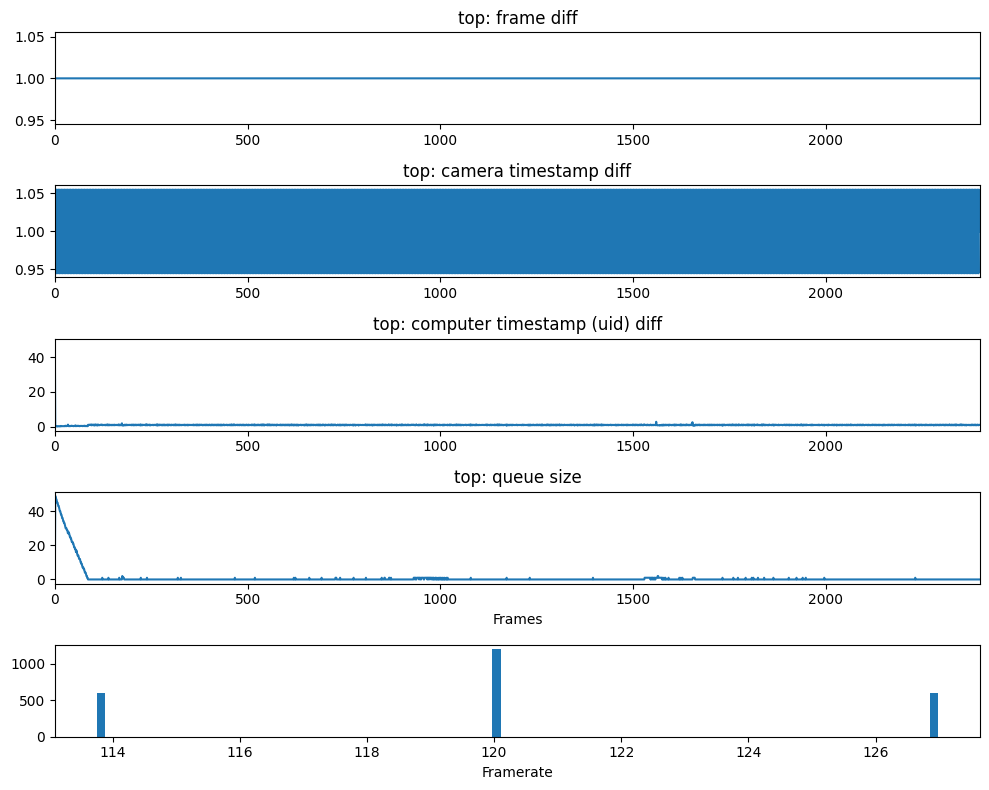

19.992
119.99844193102624
bottom


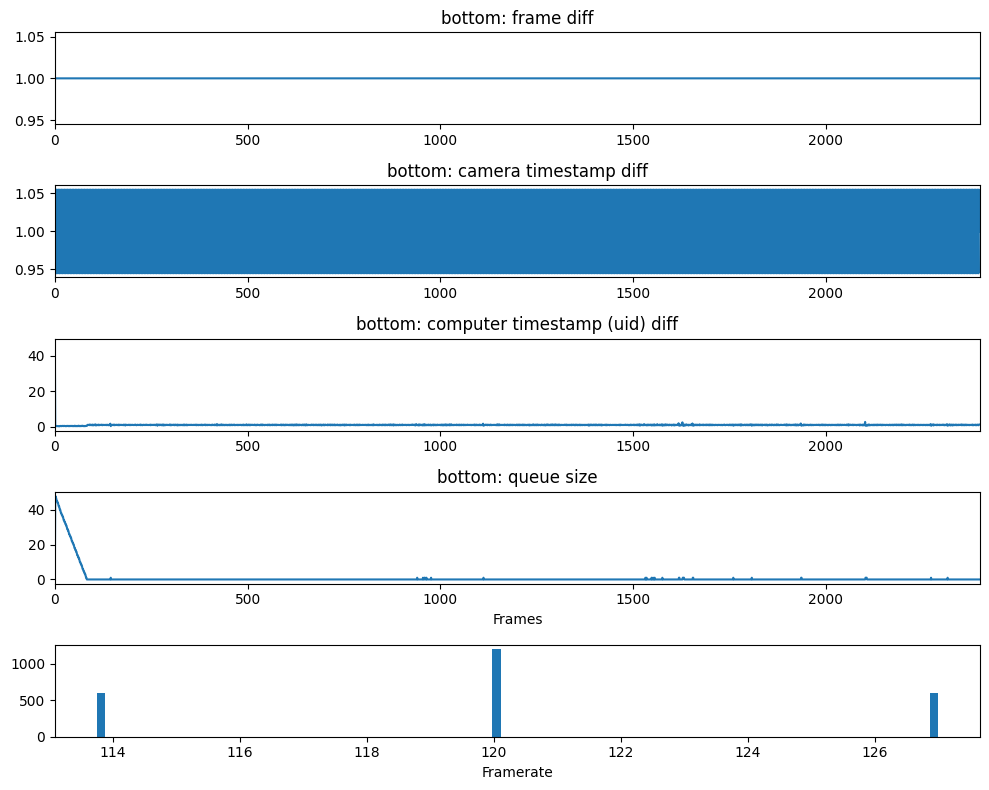

19.992
119.99788251506423
azure_top


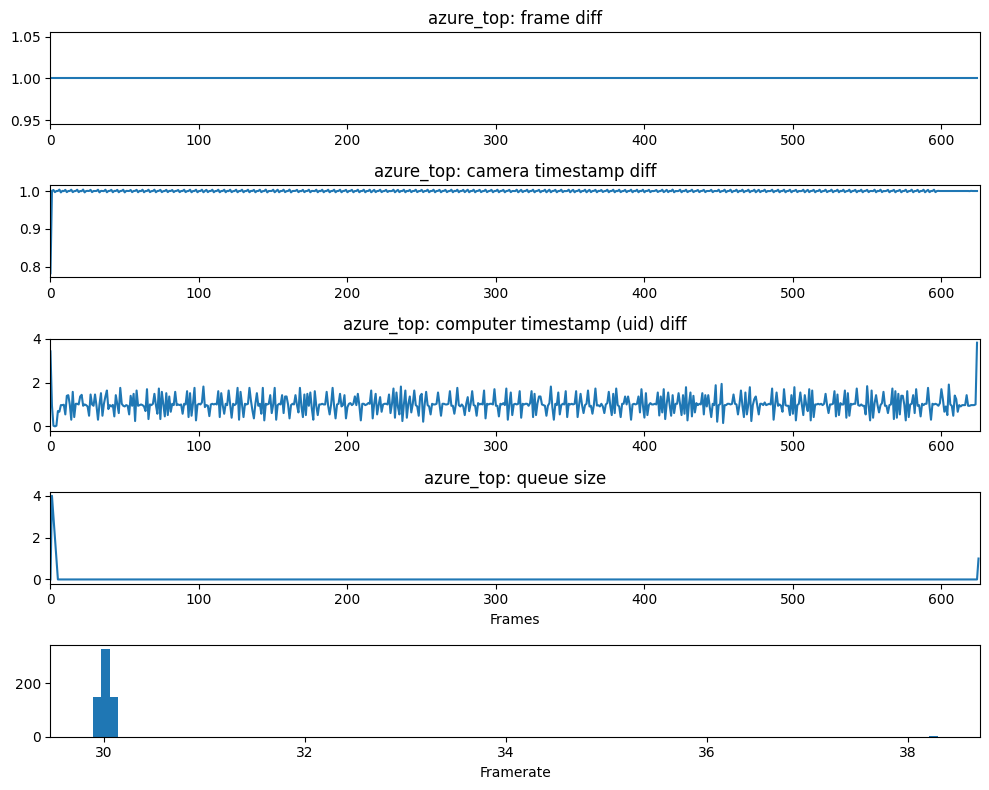

20.826
30.010372064751536
azure_bottom


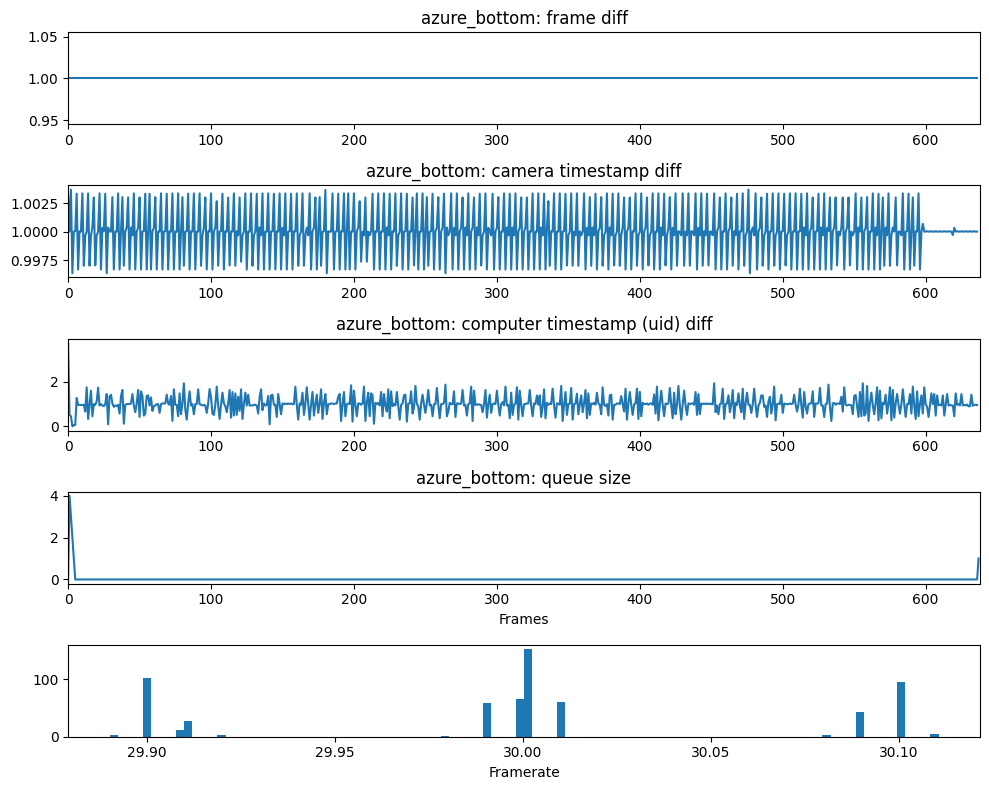

21.233
29.999812560040834


In [18]:
for cam in camera_list:
    name = cam['name']
    print(name)
    df = pd.read_csv(glob.glob(str(save_loc)+ f'\*.{name}.metadata.csv')[0])
    nrows = len(df)
    fig, axs = plt.subplots(ncols = 1, nrows = 5, gridspec_kw= {'height_ratios':[1,1,1,1,1]}, figsize=(10,8))
    
    if "azure" not in name:
        scale_factor = 1e-9  # basler ts in nanosec
    else:
        scale_factor = 1e-6  # azure ts in microsec
        
    axs[0].set_title(f"{name}: frame diff")
    axs[0].plot(np.diff(df.frames_received.values))
    axs[0].set_xlim([0, len(df)])
    axs[1].set_title(f"{name}: camera timestamp diff")
    axs[1].plot(np.diff(df.frame_timestamp.values) / np.median(np.diff(df.frame_timestamp.values)))
    #axs[1].plot(np.diff(df.frame_timestamp.values))
    axs[1].set_xlim([0, len(df)])
    axs[2].set_title(f"{name}: computer timestamp (uid) diff")
    axs[2].plot(np.diff(df.frame_image_uid.values) / np.median(np.diff(df.frame_image_uid.values)))
    axs[2].set_xlim([0, len(df)])
    axs[3].set_title(f"{name}: queue size")
    axs[3].plot(df.queue_size.values)
    axs[3].set_xlim([0, len(df)])
    axs[3].set_xlabel('Frames')
    axs[4].hist(1/(np.diff(df.frame_timestamp.values) * scale_factor), bins=100);
    axs[4].set_xlabel('Framerate')
    plt.tight_layout()
    plt.show()


    time_elapsed = (df.frame_timestamp.values[-1] - df.frame_timestamp.values[0]) * scale_factor
    avg_framerate = np.mean(np.diff(df.frame_timestamp.values))
    print(np.round(time_elapsed, 3))
    print(1 / (avg_framerate * scale_factor))
        